pytorch version is  1.9.0
Using device: cuda


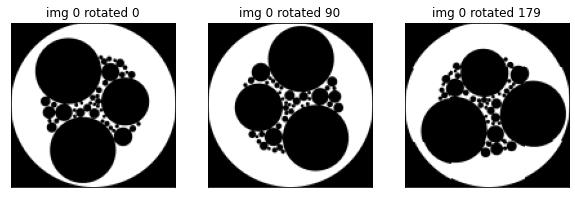

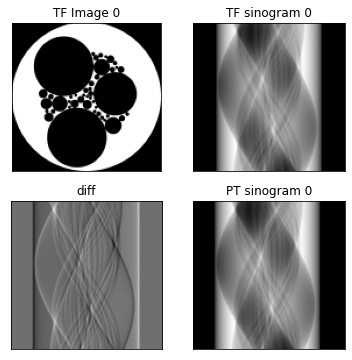

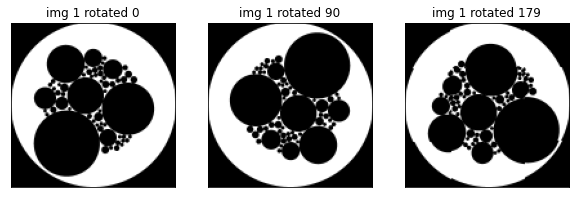

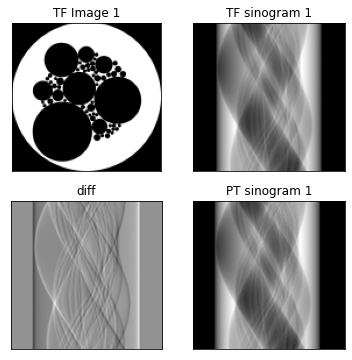

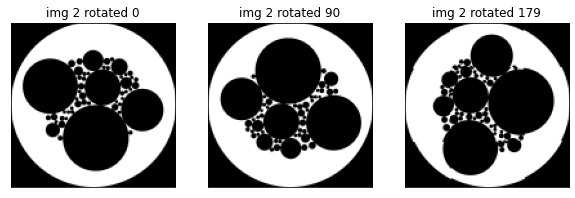

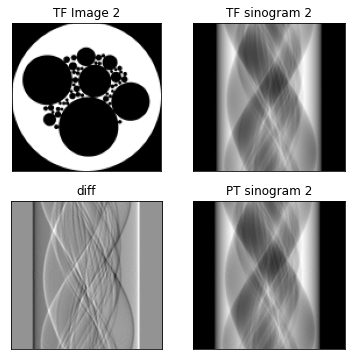

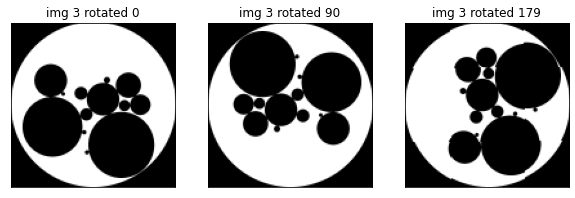

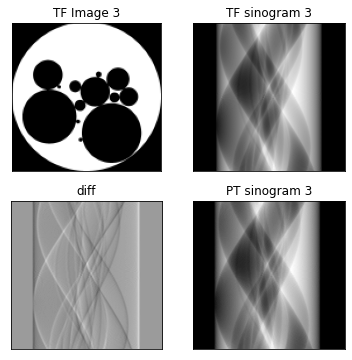

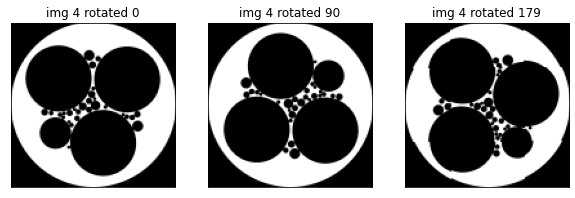

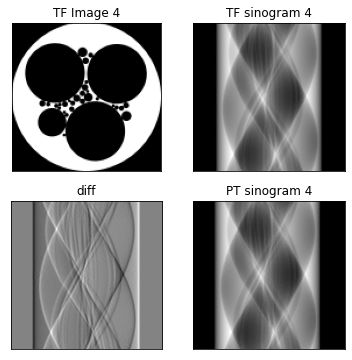

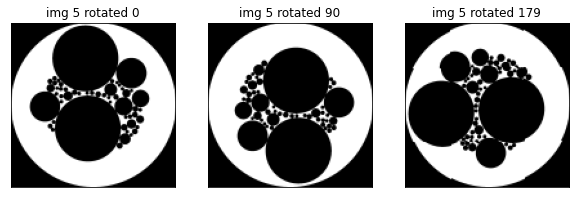

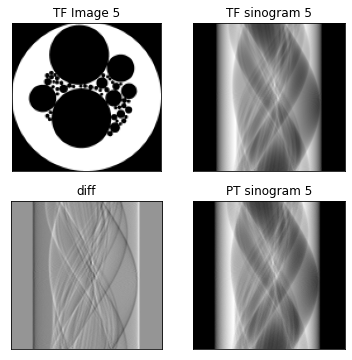

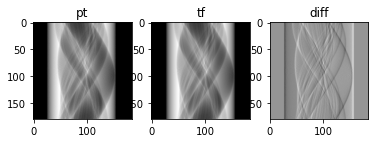

'\nprint("images shape", images_tensor.shape)\nprint("image1 shape", image.shape)\nprint("image1 dtpye", image.dtype)\nprint("tf_sinograms_tensor shape", tf_sinograms_tensor.shape)\nprint("tf_sinogram shape", tf_sinogram.shape)\nprint("tf_sinogram dtpye", tf_sinogram.dtype)\n'

In [51]:
### Author: Gary Chen
### Date: June 13, 2023
### Last Updated: Jun 15, 2023
### Description: Radon Transform (img to sinogram)
###     There's still some bug; 
###     The sinograms look like a sinograms but the second col arent the same.

try:
    import numpy as np
except Exception as e:
    print("numpy Importing exception")
try:
    import matplotlib.pyplot as plt
except Exception as e:
    print("matplotlib Importing exception")
try:
    import torch
except Exception as e:
    print("torch Importing exception")  
try:
    import torchvision.transforms.functional as F
except Exception as e:
    print("torch Importing exception")  
from torchvision import transforms
print('pytorch version is ', torch.__version__)
#%time # on Jupyter Notebook

class Data_loader:
    # load .npy file into PyTorch tensor and move it to GPU
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def npy_to_tensor(self, npy_file_path):
        np_data = np.load(npy_file_path)
        tensor = torch.from_numpy(np_data).to(self.device)
        return tensor


class Radon_Transform:
    # convert the img to sinogram
    def __init__(self):
        self.theta_num = 180
        self.angles = np.arange(90, 270, dtype=float) # Angle list
        self.size_x = None
        self.size_y = None
        
    def img_to_rotated_imgs(self, image):
        # initialize the collection of rotated iamges as 180 by 128 by 128 empty arrays
        assert type(self.theta_num) == int
        rotated_imgs = torch.zeros((self.theta_num,128, 128))
        #rotated_imgs = torch.zeros((180,128, 128))
        # assign the unrotated img as the first img in the rotated collection
        rotated_imgs[0,:,:] = image
        self.size_x = image.shape[0]
        self.size_y = image.shape[0]
        for i in range(1,self.theta_num):
            #print(f"angle type is {type(self.angles[i])}")
            #print(f"angle  is {self.angles[i]}")
            rotated_image = F.rotate(image.unsqueeze(0), -self.angles[i]) #rotate function requires img in 3-d dimension
            rotated_imgs[i,:,:] = rotated_image
        return rotated_imgs
    
    def rotated_imgs_to_sinogram(self, rotated_images):
        # initialize the summing vector
        sum_vec = torch.ones((self.size_x, 1))
        sinogram = torch.zeros((180, 184))
        assert type(self.theta_num) == int
        for i in range(self.theta_num):
        #for i in range(180):
            # ith_p is the i-th row of the sinogram corresponding to each angle
            ith_p = torch.matmul(rotated_images[i,:,:],sum_vec) # 128 by 128 @ 128 by 1 means sum across the all rows of the img
            # Calculate start index for ith row in the sinogram 
            start = (sinogram.shape[0] - ith_p.shape[0]) // 2
            # Assign p values to the ith row of the sinogram, centered
            sinogram[i,start:start+ith_p.shape[0]] = ith_p.reshape(-1)
        return sinogram 

class Display_Image:
    # display the images and sinograms and compare our implementations with CT-PVAE
    
    def display_rotated_imgs(self, rotated_images, img_id):
        rotate_fig, ax = plt.subplots(1, 3, figsize=(10, 6))
        ax[0].imshow(rotated_images[0,:,:].cpu().numpy(), cmap='gray')
        ax[0].set_xticks([])
        ax[0].set_yticks([])
        ax[0].set_title(f'img {img_id} rotated 0')
        ax[1].imshow(rotated_images[90,:,:].cpu().numpy(), cmap='gray')
        ax[1].set_xticks([])
        ax[1].set_yticks([])
        ax[1].set_title(f'img {img_id} rotated 90')
        ax[2].imshow(rotated_images[179,:,:].cpu().numpy(), cmap='gray')
        ax[2].set_xticks([])
        ax[2].set_yticks([])
        ax[2].set_title(f'img {img_id} rotated 179')
        rotate_fig.savefig(f"rotate images {img_id}")
        plt.show()
    
    def display_radon_transform(self, img, img_id, tf_sinogram,pt_sinogram):
        # Create a figure and a 1x2 subplot grid
        fig, axs = plt.subplots(2, 2, figsize=(6, 6))
        axs[0,0].imshow(img.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
        axs[0,0].set_title(f'TF Image {img_id}')
        axs[0,1].imshow(tf_sinogram.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
        axs[0,1].set_title(f'TF sinogram {img_id}')
        axs[1,0].imshow(tf_sinogram.cpu().numpy()-pt_sinogram.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
        axs[1,1].imshow(pt_sinogram.cpu().numpy(), cmap='gray')  # remove cmap='gray' if your image is colored
        axs[1,0].set_title(f'diff')
        axs[1,1].set_title(f'PT sinogram {img_id}')

        # Remove the x and y ticks
        axs[0,0].set_xticks([])
        axs[0,0].set_yticks([])
        axs[0,1].set_xticks([])
        axs[0,1].set_yticks([])
        axs[1,0].set_xticks([])
        axs[1,0].set_yticks([])
        axs[1,1].set_xticks([])
        axs[1,1].set_yticks([])
        
        fig.savefig(f"radon comp {img_id}")
        plt.show()

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'Using device: {device}')

data_loader = Data_loader()
radon_tranformer = Radon_Transform()
displayer = Display_Image()
img_id = 2
images_tensor = data_loader.npy_to_tensor('foam_training.npy')
tf_sinograms_tensor = data_loader.npy_to_tensor('x_train_sinograms.npy')
for img_id in range(6):
    image = images_tensor[img_id,:,:]
    rotated_images = radon_tranformer.img_to_rotated_imgs(image)
    pt_sinogram = radon_tranformer.rotated_imgs_to_sinogram(rotated_images)
    tf_sinogram = tf_sinograms_tensor[img_id,:,:]
    displayer.display_rotated_imgs(rotated_images, img_id)
    displayer.display_radon_transform(image, img_id, tf_sinogram,pt_sinogram)

def plot_2_img_tensor(image1, image2, title1, title2):
    fig, axs = plt.subplots(1, 3)
    axs[0].imshow(image1.cpu().numpy(), cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2.cpu().numpy(), cmap='gray')
    axs[1].set_title(title2)
    axs[2].imshow(image2.cpu().numpy()-image1.cpu().numpy(), cmap='gray')
    '''
    print('img 1 is', image1[50:60, 50:60])
    print('img 2 is', image2[50:60, 50:60])
    print('diff is', image2.cpu().numpy()[50:60, 50:60]-image1.cpu().numpy()[50:60, 50:60])
    '''
    axs[2].set_title('diff')
    plt.show()
    
plot_2_img_tensor(pt_sinogram,tf_sinogram,"pt","tf")

'''
print("images shape", images_tensor.shape)
print("image1 shape", image.shape)
print("image1 dtpye", image.dtype)
print("tf_sinograms_tensor shape", tf_sinograms_tensor.shape)
print("tf_sinogram shape", tf_sinogram.shape)
print("tf_sinogram dtpye", tf_sinogram.dtype)
'''

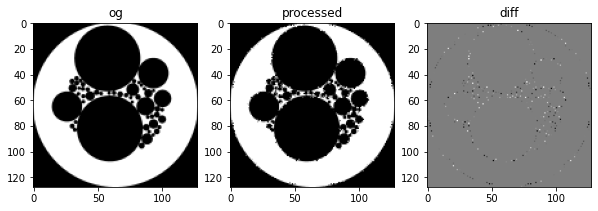

In [48]:
rotate_angle = 60
a = rotated_images[0]
b = rotated_images[rotate_angle]
c = F.rotate(b.unsqueeze(0),rotate_angle+90)
c = c.reshape(128,128)
def plot_2_img_tensor(image1, image2, title1, title2):
    fig, axs = plt.subplots(1, 3,figsize=(10, 6))
    axs[0].imshow(image1.cpu().numpy(), cmap='gray')
    axs[0].set_title(title1)
    axs[1].imshow(image2.cpu().numpy(), cmap='gray')
    axs[1].set_title(title2)
    axs[2].imshow(image2.cpu().numpy()-image1.cpu().numpy(), cmap='gray')
    '''
    print('img 1 is', image1[50:60, 50:60])
    print('img 2 is', image2[50:60, 50:60])
    print('diff is', image2.cpu().numpy()[50:60, 50:60]-image1.cpu().numpy()[50:60, 50:60])
    '''
    axs[2].set_title('diff')
    plt.show()
plot_2_img_tensor(a,c,'og','processed')